## Constituency dataset validation


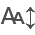

In [1]:
from policyengine_uk import Microsimulation
import pandas as pd
import h5py
from itables import init_notebook_mode
import itables.options as opt
from pathlib import Path
from policyengine.utils.huggingface import download
from policyengine_uk_data.storage import STORAGE_FOLDER

opt.maxBytes = "1MB"
init_notebook_mode(all_interactive=True)

REPO = Path(".").resolve().parent

weights_file_path = STORAGE_FOLDER / "parliamentary_constituency_weights.h5"
with h5py.File(weights_file_path, "r") as f:
        weights = f[str(2025)][...]
constituency_names_file_path = download(
    repo="policyengine/policyengine-uk-data",
    repo_filename="constituencies_2024.csv",
    local_folder=None,
    version=None,
)
constituencies_2024 = pd.read_csv(constituency_names_file_path)

baseline = Microsimulation()
household_weights = baseline.calculate("household_weight", 2025).values

from policyengine_uk_data.datasets.frs.local_areas.constituencies.loss import create_constituency_target_matrix, create_national_target_matrix

constituency_target_matrix, constituency_actuals = create_constituency_target_matrix("enhanced_frs_2022_23", 2025, None)
national_target_matrix, national_actuals = create_national_target_matrix("enhanced_frs_2022_23", 2025, None)

constituency_wide = weights @ constituency_target_matrix
constituency_wide.index = constituencies_2024.code.values
constituency_wide["name"] = constituencies_2024.name.values

constituency_results = pd.melt(constituency_wide.reset_index(), id_vars=["index", "name"], var_name="variable", value_name="value")

constituency_actuals.index = constituencies_2024.code.values
constituency_actuals["name"] = constituencies_2024.name.values
constituency_actuals_long = pd.melt(constituency_actuals.reset_index(), id_vars=["index", "name"], var_name="variable", value_name="value")

constituency_target_validation = pd.merge(constituency_results, constituency_actuals_long, on=["index", "variable"], suffixes=("_target", "_actual"))
constituency_target_validation.drop("name_actual", axis=1, inplace=True)
constituency_target_validation.columns = ["index", "name", "metric", "estimate", "target"]

constituency_target_validation["error"] = constituency_target_validation["estimate"] - constituency_target_validation["target"]
constituency_target_validation["abs_error"] = constituency_target_validation["error"].abs()
constituency_target_validation["rel_abs_error"] = constituency_target_validation["abs_error"] / constituency_target_validation["target"]

### Calibration check
Looking at the sorted validation results by relative absolute error shows how well our calibrated weights perform against the actual target statistics across UK parliamentary constituencies under the new 2024 boundaries. The table reveals the accuracy of our estimates, from the closest matches to the largest discrepancies, where a lower relative error indicates better calibration performance.

In [2]:
constituency_target_validation.sort_values("rel_abs_error")

index                            name  \
10276  E14001589                     Wirral West   
5283   E14001146  Bury St Edmunds and Stowmarket   
4154   E14001317                        Knowsley   
5855   E14001068                        Ashfield   
5197   W07000110               Vale of Glamorgan   
...          ...                             ...   
6842   E14001405              North West Norfolk   
7791   W07000104                    Newport East   
7141   W07000104                    Newport East   
6643   E14001206  Dunstable and Leighton Buzzard   
7293   E14001206  Dunstable and Leighton Buzzard   

                                          metric      estimate        target  \
10276  hmrc/employment_income/amount/20000_30000  1.322333e+08  1.322420e+08   
5283                                   age/60_70  1.451102e+04  1.450993e+04   
4154                                   age/40_50  1.269529e+04  1.269403e+04   
5855                                   age/70_80  1.078475e+04  1.078346e+04   
5197                                   age/50_60  1.489186e+04  1.489368e+04   
...                                          ...           ...           ...   
6842    hmrc/employment_income/count/12570_15000  8.755749e+02  8.431956e+01   
7791   hmrc/employment_income/amount/12570_15000  1.544117e+07  1.432437e+06   
7141    hmrc/employment_income/count/12570_15000  1.118195e+03  1.031530e+02   
6643    hmrc/employment_income/count/12570_15000  7.247283e+02  6.187779e+01   
7293   hmrc/employment_income/amount/12570_15000  1.006603e+07  8.592676e+05   

              error     abs_error  rel_abs_error  
10276 -8.699413e+03  8.699413e+03       0.000066  
5283   1.083593e+00  1.083593e+00       0.000075  
4154   1.256512e+00  1.256512e+00       0.000099  
5855   1.288091e+00  1.288091e+00       0.000119  
5197  -1.817116e+00  1.817116e+00       0.000122  
...             ...           ...            ...  
6842   7.912553e+02  7.912553e+02       9.384007  
7791   1.400874e+07  1.400874e+07       9.779649  
7141   1.015042e+03  1.015042e+03       9.840155  
6643   6.628505e+02  6.628505e+02      10.712253  
7293   9.206761e+06  9.206761e+06      10.714661  

[14300 rows x 8 columns]

In [3]:
national_performance = household_weights @ national_target_matrix
national_target_validation = pd.DataFrame({"metric": national_performance.index, "estimate": national_performance.values})
national_target_validation["target"] = national_actuals.values

national_target_validation["error"] = national_target_validation["estimate"] - national_target_validation["target"]
national_target_validation["abs_error"] = national_target_validation["error"].abs()
national_target_validation["rel_abs_error"] = national_target_validation["abs_error"] / national_target_validation["target"]

The table below shows the relative absolute error for each calibration target at the **national level**, sorted from the closest matches to the largest discrepancies.

In [4]:
national_target_validation.sort_values("rel_abs_error")

metric      estimate  \
32                                     obr/tax_credits  8.193125e+07   
273  hmrc/property_income_income_band_51_200_000.0_...  1.279169e+09   
302  hmrc/property_income_count_income_band_53_500_...  1.308427e+04   
67                           ons/west_midlands_age_0_9  7.012820e+05   
110                           ons/south_west_age_70_79  6.602741e+05   
..                                                 ...           ...   
283  hmrc/state_pension_income_band_52_300_000.0_to...  1.339890e+08   
14                            obr/pension_credit_count  1.808012e+06   
38                           obr/winter_fuel_allowance  5.880389e+08   
18                     obr/winter_fuel_allowance_count  2.447219e+06   
25                                  obr/domestic_rates  0.000000e+00   

           target         error     abs_error  rel_abs_error  
32  -1.000000e+08  1.819312e+08  1.819312e+08      -1.819312  
273  1.278761e+09  4.083231e+05  4.083231e+05       0.000319  
302  1.306200e+04  2.226575e+01  2.226575e+01       0.001705  
67   7.000000e+05  1.281977e+03  1.281977e+03       0.001831  
110  6.620000e+05 -1.725882e+03  1.725882e+03       0.002607  
..            ...           ...           ...            ...  
283  2.089727e+08 -7.498374e+07  7.498374e+07       0.358821  
14   1.300000e+06  5.080119e+05  5.080119e+05       0.390778  
38   1.900000e+09 -1.311961e+09  1.311961e+09       0.690506  
18   1.100000e+07 -8.552781e+06  8.552781e+06       0.777526  
25   4.000000e+08 -4.000000e+08  4.000000e+08       1.000000  

[335 rows x 6 columns]